In [1]:
from datetime import datetime
import yaml
from backbone.utils.general_purpose import load_function
from backbone.utils.wfo_utils import optimization_function, run_wfo
from backbone.utils.wfo_utils import run_strategy

root = './backbone/data'

with open('configs/live_trading.yml', 'r') as file:
    strategies = yaml.safe_load(file)

with open('configs/test_creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

date_from = datetime(2020, 1, 1)
date_to = datetime(2024, 10, 22)

run = [
    'backbone.channel_strategy.Channel',
    'backbone.bbands_cross_strategy.BbandsCross',
    'backbone.mean_reversion_strategy.MeanReversion',
    # 'backbone.b_percent_strategy.BPercent',
    # 'backbone.day_per_week_strategy.DayPerWeek',
    
    
    # 'backbone.macd_trader.MacdTrader',
    # 'backbone.vix_trader.VixTrader',    
    # 'backbone.eom_trader.EndOfMonthTrader',
]

equity_curves = {}
trades = {}
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4


bot_path = 'backbone.trader_bot.TraderBot'

for strategy_name, configs in strategies.items():
    
    print(strategy_name)
    
    if strategy_name not in run:
        continue
    
    instruments_info = configs['instruments_info']
    wfo_params = configs['wfo_params']
    opt_params = configs['opt_params']
    name = configs['name']

    for ticker, info in instruments_info.items():
        cron = info['cron']
        timeframe = info['timeframe']
        
        print(strategy_name, ticker, timeframe)

        strategy = load_function(strategy_name)
        
        bot = load_function(bot_path)(name, ticker, timeframe, creds, opt_params, wfo_params, strategy)
    
        df = bot.get_data(date_from, date_to)
        
        configs = strategies[strategy_name]

        instruments_info = configs['instruments_info']
        wfo_params = configs['wfo_params']
        opt_params = configs['opt_params']

        _, _, optimized_params = run_wfo(
            strategy=bot.strategy,
            ticker=ticker,
            interval=timeframe,
            prices=df,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=bot.opt_params,
            lookback_bars=bot.wfo_params['look_back_bars'],
            warmup_bars=bot.wfo_params['warmup_bars'],
            validation_bars=250,
            plot=False
        )
        
        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=timeframe,
            commission=COMMISSION, 
            prices=df, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=optimized_params, 
            plot=True
        )

        equity_curves[bot.name] = stats['_equity_curve']
        trades[bot.name] = stats['_trades']

backbone.b_percent_strategy.BPercent
backbone.mean_reversion_strategy.MeanReversion
backbone.mean_reversion_strategy.MeanReversion UNHm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.28
  equity=1396.54
  margin=207.05
  margin_free=1189.49
  margin_level=674.4940835546969
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.mean_reversion_strategy.MeanReversion IQm H2
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.28
  equity=1396.54
  margin=207.05
  margin_free=1189.49
  margin_level=674.4940835546969
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.day_per_week_strategy.DayPerWeek
backbone.bbands_cross_strategy.BbandsCross
backbone.bbands_cross_strategy.BbandsCross JPMm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.23
  equity=1396.49
  margin=207.05
  margin_free=1189.44
  margin_level=674.4699347983578
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross ADBEm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.21
  equity=1396.47
  margin=207.05
  margin_free=1189.42
  margin_level=674.4602752958223
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross SBUXm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.23
  equity=1396.49
  margin=207.05
  margin_free=1189.44
  margin_level=674.4699347983578
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross BBm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.2
  equity=1396.46
  margin=207.05
  margin_free=1189.41
  margin_level=674.4554455445544
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross BILIm H2
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.14
  equity=1396.4
  margin=207.05
  margin_free=1189.35
  margin_level=674.4264670369475
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross PYPLm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.14
  equity=1396.4
  margin=207.05
  margin_free=1189.35
  margin_level=674.4264670369475
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.bbands_cross_strategy.BbandsCross METAm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.15
  equity=1396.41
  margin=207.05
  margin_free=1189.36
  margin_level=674.4312967882154
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


backbone.channel_strategy.Channel
backbone.channel_strategy.Channel USTECm H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1382.26
  credit=0.0
  profit=14.16
  equity=1396.42
  margin=207.05
  margin_free=1189.37
  margin_level=674.4361265394832
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [2]:
equity_curves.keys()

dict_keys(['MeanRev_UNHm_H4', 'MeanRev_IQm_H2', 'BbandsCross_JPMm_H4', 'BbandsCross_ADBEm_H4', 'BbandsCross_SBUXm_H4', 'BbandsCross_BBm_H4', 'BbandsCross_BILIm_H2', 'BbandsCross_PYPLm_H4', 'BbandsCross_METAm_H4', 'Channel_USTECm_H4'])

In [84]:
import pandas as pd

min_date = None
max_date = None

for name, curve in equity_curves.items():
    # Convertir las fechas a UTC si son tz-naive
    actual_date = curve.index[0].tz_localize('UTC') if curve.index[0].tz is None else curve.index[0].tz_convert('UTC')
    
    # Si min_date es None, inicializar con la primera fecha
    if min_date is None:
        min_date = actual_date
    # Comparar si la fecha actual es menor que min_date
    elif actual_date < min_date:
        min_date = actual_date

    # Si max_date es None, inicializar con la última fecha
    curve_last_date = curve.index[-1].tz_localize('UTC') if curve.index[-1].tz is None else curve.index[-1].tz_convert('UTC')
    
    if max_date is None:
        max_date = curve_last_date
    # Comparar si la fecha actual es mayor que max_date
    elif curve_last_date > max_date:
        max_date = curve_last_date

# Mostrar las fechas encontradas
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

# Calcular min_date y max_date
min_date = min_date.date()
max_date = max_date.date()

print(min_date)
print(max_date)

date_range = pd.to_datetime(pd.date_range(start=min_date, end=max_date, freq='D'))
print(date_range)

Min Date: 2020-01-02 00:00:00+00:00
Max Date: 2024-10-22 00:00:00+00:00


AttributeError: 'datetime.date' object has no attribute 'dt'

In [80]:
percentual_differences = {}

def get_percentual_differences(equity_curves, trades):
    for name, curve in equity_curves.items():
        trade_df = trades[name]
        equity_df = equity_curves[name]
        
        
        trade_df['ExitTime'] = trade_df['ExitTime'].dt.floor('D')
        
        trade_df = pd.DataFrame(trade_df.groupby('ExitTime')['PnL'].sum()).reindex(date_range)
        trade_df.fillna(0, inplace=True)
        
        equity_df = equity_df.reset_index().rename(columns={'index':'Date'})
        equity_df['Date'] = pd.to_datetime(equity_df['Date'])
        equity_df['Date'] = equity_df['Date'].dt.floor('D')
        
        equity_df = pd.DataFrame(equity_df.groupby('Date')['Equity'].last()).reindex(date_range)
        equity_df.ffill(inplace=True)
        equity_df.fillna(INITIAL_CASH, inplace=True)
  
        pct_df = pd.merge(
            trade_df,
            equity_df,
            left_index=True,
            right_index=True
        )

        pct_df['pct'] = pct_df['PnL'] / pct_df['Equity'].shift(1)
        
        percentual_differences[name] = pct_df
    
    percentual_differences


differences = get_percentual_differences(equity_curves, trades)
differences

ValueError: <MonthEnd> is a non-fixed frequency

In [47]:

def get_hipotetical_wallet_equity(equity_curves, initial_equity):
    total = pd.DataFrame()
    variaciones_porcentuales = {}

    for name, curve in equity_curves.items():

        eq = equity_curves[name].copy()
        eq = eq.reset_index().rename(columns={'index':'Date'})[['Date','Equity']].sort_values(by='Date')
        eq['Date'] = pd.to_datetime(eq['Date'])
        eq['Date'] = eq['Date'].dt.floor('D')

        eq = eq.groupby('Date').agg({'Equity':'last'})

        eq = eq.reindex(date_range)
        
        eq.Equity = eq.Equity.ffill()
        eq.Equity = eq.Equity.fillna(INITIAL_CASH)
    
        eq['variacion'] = eq['Equity'] - eq['Equity'].shift(1)
        eq['variacion_porcentual'] = eq['variacion'] / eq['Equity'].shift(1)
        
        df_variacion = pd.DataFrame(
            {
                f'variacion_{name}': eq.variacion_porcentual.fillna(0)
            }
        )
        
        total = pd.concat([total, df_variacion], axis=1)

    total = total.reset_index().rename(columns={'index':'Date'})

    # Inicializa el valor de equity
    total['Equity'] = initial_equity

    # Lista de columnas con las variaciones porcentuales
    variation_cols = [col for col in total.columns if col.startswith('variacion')]

    # Calcular la curva de equity
    for i in range(1, len(total)):
        previous_equity = total.loc[i-1, 'Equity']  # Equity del periodo anterior
        
        # Calcula el impacto monetario de cada bot por separado y suma el resultado
        impact_sum = 0
        for col in variation_cols:
            variation = total.loc[i, col]
            impact_sum += previous_equity * variation
        
        # Actualiza el equity sumando el impacto monetario total
        total.loc[i, 'Equity'] = previous_equity + impact_sum

    # Resultado final

    total = total.set_index('Date')
    return total[['Equity']]

In [56]:
if 'variaciones_porcentuales' in equity_curves.keys():
    del equity_curves['variaciones_porcentuales']

initial_equity = 10000
total = get_hipotetical_wallet_equity(equity_curves=equity_curves, initial_equity=initial_equity)
equity_curves['variaciones_porcentuales'] = total


In [49]:
equity_curves.keys()

dict_keys(['MeanRev_UNHm_H4', 'MeanRev_IQm_H2', 'BbandsCross_JPMm_H4', 'BbandsCross_ADBEm_H4', 'BbandsCross_SBUXm_H4', 'BbandsCross_BBm_H4', 'BbandsCross_BILIm_H2', 'BbandsCross_PYPLm_H4', 'BbandsCross_METAm_H4', 'Channel_USTECm_H4', 'variaciones_porcentuales'])

In [50]:
import plotly.graph_objects as go

# Crear una figura vacía
fig = go.Figure()

# Recorrer las curvas de equity de cada bot y agregarlas al gráfico
for k, v in equity_curves.items():
    
    fig.add_trace(go.Scatter(x=v.index, y=v.Equity, mode='lines', name=k))

# Actualizar los detalles del layout del gráfico
fig.update_layout(
    title="Curvas de Equity de Múltiples Bots",
    xaxis_title="Fecha",
    yaxis_title="Equity",
    legend_title="Bots"
)

# Mostrar el gráfico
fig.show()


In [51]:
import numpy as np

def max_drawdown(equity_curve):
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max
    return np.min(drawdown) * 100  # Convertir el drawdown a porcentaje

max_drawdown(equity_curves['variaciones_porcentuales'].Equity)

-11.81179006238381

In [53]:
del equity_curves['variaciones_porcentuales']

# Correlaciones

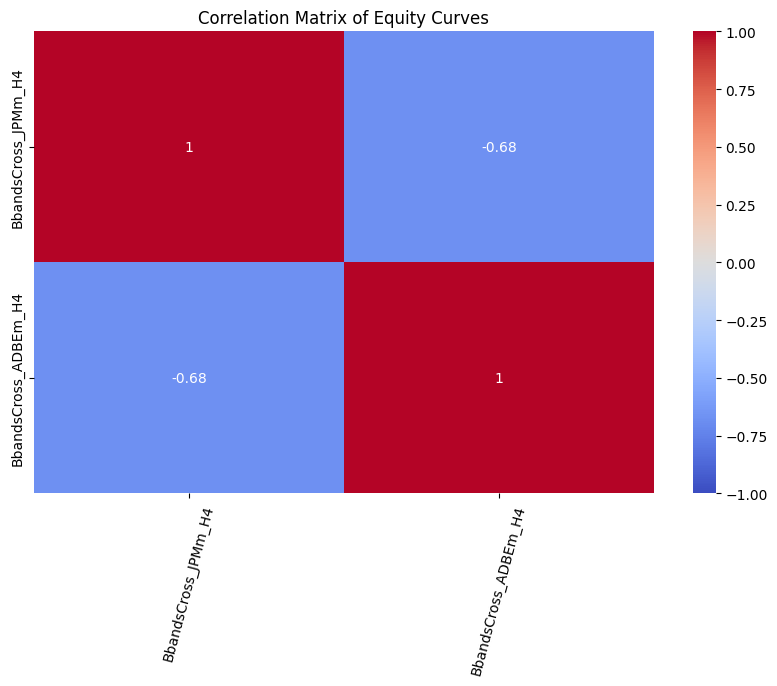

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in differences.items():
    all_equity_df[name] = df['pct']


all_equity_df = all_equity_df[['BbandsCross_JPMm_H4','BbandsCross_ADBEm_H4']]
all_equity_df = all_equity_df[~(all_equity_df == 0).all(axis=1)]

# Paso 2: Calcular la matriz de correlación
correlation_matrix = all_equity_df.corr(method='pearson')

# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=75)
plt.show()

In [76]:
all_equity_df[(all_equity_df['BbandsCross_JPMm_H4'] != 0) & (all_equity_df['BbandsCross_ADBEm_H4'] != 0)]


,BbandsCross_JPMm_H4,BbandsCross_ADBEm_H4
2022-06-10,90.797630,50.476340
2024-10-07,192.105753,-317.162142


In [78]:
all_equity_df.shape

(22, 2)

In [57]:
(equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).mean()

Equity    22.57182
dtype: float64

In [58]:
(equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).std()

Equity    243.619873
dtype: float64

In [59]:
all_equity_df.describe()

,MeanRev_UNHm_H4,MeanRev_IQm_H2,BbandsCross_JPMm_H4,BbandsCross_ADBEm_H4,BbandsCross_SBUXm_H4,BbandsCross_BBm_H4,BbandsCross_BILIm_H2,BbandsCross_PYPLm_H4,BbandsCross_METAm_H4,Channel_USTECm_H4
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,11.436431,4.436606,2.372649,1.251942,2.257166,3.447003,4.487457,3.064579,4.970716,6.524505
std,95.688192,113.541726,16.278772,22.837210,15.027117,37.861248,47.719866,28.779394,75.348631,108.231133
min,-266.615424,-401.624000,0.000000,-317.162142,-3.611888,-114.436948,-348.763568,-103.349513,-380.499367,-235.394689
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,696.162512,718.177632,192.105753,230.337928,207.859192,607.529000,353.568504,449.388230,812.705364,785.994766


In [68]:
summary = all_equity_df.describe()
mean_std = summary.loc['std'].mean()
mean_std

56.13132887808363

In [70]:
summary.loc['std'].mean() / summary.loc['mean'].mean()

12.685316915340989

In [71]:
(equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).std() / (equity_curves['variaciones_porcentuales'] - equity_curves['variaciones_porcentuales'].shift(1)).mean()

Equity    10.793098
dtype: float64

In [12]:
uncorrelation_matrix = correlation_matrix[correlation_matrix < 0.6]
uncorrelation_matrix

,MeanRev_UNHm_H4,MeanRev_IQm_H2,BbandsCross_JPMm_H4,BbandsCross_ADBEm_H4,BbandsCross_SBUXm_H4,BbandsCross_BBm_H4,BbandsCross_BILIm_H2,BbandsCross_PYPLm_H4,BbandsCross_METAm_H4,Channel_USTECm_H4
MeanRev_UNHm_H4,NaN,-0.027986,0.014596,-0.002383,-0.007593,-0.025226,0.017515,-0.013253,-0.054657,-0.015202
MeanRev_IQm_H2,-0.027986,NaN,0.006461,0.041875,0.005823,-0.012768,0.063324,0.001344,-0.030846,-0.014012
BbandsCross_JPMm_H4,0.014596,0.006461,NaN,-0.366498,-0.022455,-0.013389,-0.014022,0.005496,-0.009627,-0.070685
BbandsCross_ADBEm_H4,-0.002383,0.041875,-0.366498,NaN,-0.008607,-0.014500,-0.005374,0.002386,-0.003690,0.036016
BbandsCross_SBUXm_H4,-0.007593,0.005823,-0.022455,-0.008607,NaN,-0.013791,-0.044127,-0.016099,-0.009917,-0.026733
BbandsCross_BBm_H4,-0.025226,-0.012768,-0.013389,-0.014500,-0.013791,NaN,-0.008612,-0.009599,-0.005913,-0.005340
BbandsCross_BILIm_H2,0.017515,0.063324,-0.014022,-0.005374,-0.044127,-0.008612,NaN,-0.031354,-0.006192,0.016179
BbandsCross_PYPLm_H4,-0.013253,0.001344,0.005496,0.002386,-0.016099,-0.009599,-0.031354,NaN,0.012272,0.004518
BbandsCross_METAm_H4,-0.054657,-0.030846,-0.009627,-0.003690,-0.009917,-0.005913,-0.006192,0.012272,NaN,0.000305
Channel_USTECm_H4,-0.015202,-0.014012,-0.070685,0.036016,-0.026733,-0.005340,0.016179,0.004518,0.000305,NaN


In [13]:
highcorrelation_matrix = correlation_matrix[correlation_matrix > 0.6]
highcorrelation_matrix

,MeanRev_UNHm_H4,MeanRev_IQm_H2,BbandsCross_JPMm_H4,BbandsCross_ADBEm_H4,BbandsCross_SBUXm_H4,BbandsCross_BBm_H4,BbandsCross_BILIm_H2,BbandsCross_PYPLm_H4,BbandsCross_METAm_H4,Channel_USTECm_H4
MeanRev_UNHm_H4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MeanRev_IQm_H2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BbandsCross_JPMm_H4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BbandsCross_ADBEm_H4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
BbandsCross_SBUXm_H4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
BbandsCross_BBm_H4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
BbandsCross_BILIm_H2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
BbandsCross_PYPLm_H4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
BbandsCross_METAm_H4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Channel_USTECm_H4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [14]:
a = [0.02, -0.01, 0.05, 0.03, -0.02]
b = [0.01, -0.02, 0.04, 0.01, -0.01]

pd.DataFrame({'a':a, 'b':b,}).corr()

,a,b
a,1.000000,0.934791
b,0.934791,1.000000
